In [8]:
import numpy as np
import tensorflow as tf
import random as python_random

from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report
import datetime
import os
# for reproducibility purposes
np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

# load tensorboard
%reload_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 28900), started 21:50:39 ago. (Use '!kill 28900' to kill it.)

In [9]:
def make_directories():
    d = datetime.datetime.today()
    timestamp = d.strftime('%Y%m%d_%H%M%S')
    # folder to store the tensorboard logs
    tensorlog_folder = os.path.join(os.path.curdir, 'logs', timestamp)
    # folder to store the trained models
    checkpoint_folder = os.path.join(os.path.curdir, 'models', timestamp)

    os.mkdir(tensorlog_folder)
    os.mkdir(checkpoint_folder)

    return checkpoint_folder, tensorlog_folder

In [10]:
# 0: T-shirt/top, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat, 5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle boot
data = datasets.fashion_mnist
(train_imgs, train_lbls), (test_imgs, test_lbls) = data.load_data()

print(train_imgs.shape)
print(test_imgs.shape)

(60000, 28, 28)
(10000, 28, 28)


In [11]:
# normalize the image data
train_imgs = train_imgs.astype('float32') / 255
test_imgs = test_imgs.astype('float32') / 255

print(Counter(train_lbls))
print(Counter(test_lbls))

Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})
Counter({9: 1000, 2: 1000, 1: 1000, 6: 1000, 4: 1000, 5: 1000, 7: 1000, 3: 1000, 8: 1000, 0: 1000})


5


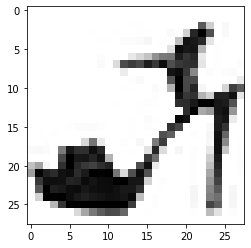

In [12]:
# print an image
print(train_lbls[9])
image = train_imgs[9]
# print(type(image), image.shape, image)
plt.imshow(image, cmap=plt.cm.binary)
plt.show()

In [13]:
# using the keras sequential model
model = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu', name='dense_1'),
    layers.Dense(10, activation='softmax', name='dense_out')
])

# print the model summary
print(model.summary())

# compile the model
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# get the required directories
check_dir, tboard_dir = make_directories()

# using the callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoints = keras.callbacks.ModelCheckpoint(
    filepath=check_dir,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

tensorboard = keras.callbacks.TensorBoard(
    log_dir=tboard_dir
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

# fit the model with training data with a validation split
# by default .fit will shuffle the data
model.fit(
    train_imgs, 
    train_lbls, 
    validation_split=0.3, 
    epochs=10, 
    batch_size=64, 
    callbacks=[reduce_lr, early_stop, checkpoints, tensorboard]
)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_out (Dense)            (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
657/657 [==============================] - 4s 4ms/step - loss: 0.5740 - accuracy: 0.7994 - val_loss: 0.5337 - val_accuracy: 0.8122
INFO:tensorflow:Assets written to: .\models\20220331_184156\assets
Epoch 2/10
657/657 [==============================] - 2s 4ms/step - loss: 0.4139 - accuracy: 0.8517 - val_loss: 0.3927 - val_accuracy: 0.8573
INFO:tensorflow:Assets w

In [14]:
# evaluate the model on the test data
test_evals = model.evaluate(test_imgs, test_lbls)
print(test_evals)
# predict on the test data
predictions = model.predict(test_imgs)
predicted_lbls = np.argmax(predictions, axis=1)
cr = classification_report(test_lbls, predicted_lbls)
print(cr)

313/313 [==============================] - 0s 1ms/step - loss: 0.3473 - accuracy: 0.8796
[0.3473190367221832, 0.8795999884605408]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.77      0.83      0.79      1000
           3       0.86      0.91      0.88      1000
           4       0.80      0.79      0.79      1000
           5       0.97      0.96      0.96      1000
           6       0.72      0.64      0.68      1000
           7       0.92      0.96      0.94      1000
           8       0.96      0.97      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [15]:
# limitations with the sequential model
# single input and output
# sequence of layers

# using the functional API
# can be used with multiple inputs and outputs

# using the keras functional API
inputs = keras.Input(shape=(28,28))
x = layers.Flatten()(inputs)
x = layers.Dense(128, activation='relu', name='dense_1')(x)

outputs = layers.Dense(10, activation='softmax', name='dense_out')(x)

# creating the Model by grouping the layers
model = keras.Model(inputs=inputs, outputs=outputs)

# print the model summary
print(model.summary())

# compile the model
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# get the required directories
check_dir, tboard_dir = make_directories()

# using the callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoints = keras.callbacks.ModelCheckpoint(
    filepath=check_dir,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

tensorboard = keras.callbacks.TensorBoard(
    log_dir=tboard_dir
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

# fit the model with training data with a validation split
# by default .fit will shuffle the data
model.fit(
    train_imgs, 
    train_lbls, 
    validation_split=0.3, 
    epochs=10, 
    batch_size=64, 
    callbacks=[reduce_lr, early_stop, checkpoints, tensorboard]
)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_out (Dense)            (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
657/657 [==============================] - 3s 4ms/step - loss: 0.5631 - accuracy: 0.8013 - val_loss: 0.5031 - val_accuracy: 0.8259
INFO:tensorflow:Assets written to: .\models\20220331_184223\assets
Epoch 2/10
657/657 [===================

In [16]:
# evaluate the model on the test data
test_evals = model.evaluate(test_imgs, test_lbls)
print(test_evals)
# predict on the test data
predictions = model.predict(test_imgs)
predicted_lbls = np.argmax(predictions, axis=1)
cr = classification_report(test_lbls, predicted_lbls)
print(cr)

313/313 [==============================] - 0s 1ms/step - loss: 0.3461 - accuracy: 0.8791
[0.34606388211250305, 0.8791000247001648]
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.77      0.82      0.79      1000
           3       0.85      0.90      0.88      1000
           4       0.79      0.80      0.79      1000
           5       0.96      0.96      0.96      1000
           6       0.74      0.63      0.68      1000
           7       0.92      0.96      0.94      1000
           8       0.96      0.98      0.97      1000
           9       0.97      0.94      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [17]:
data = datasets.fashion_mnist
(train_imgs, train_lbls), (test_imgs, test_lbls) = data.load_data()

# reshape and normalize data for CNN
train_imgs = train_imgs.reshape((60000, 28, 28, 1)) 
train_imgs = train_imgs.astype("float32") / 255 
test_imgs = test_imgs.reshape((10000, 28, 28, 1)) 
test_imgs = test_imgs.astype("float32") / 255 

In [18]:
inputs = keras.Input(shape=(28, 28, 1)) 
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs) 
x = layers.MaxPooling2D(pool_size=2)(x) 
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x) 
x = layers.MaxPooling2D(pool_size=2)(x) 
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x) 
x = layers.Flatten()(x)

outputs = layers.Dense(10, activation="softmax")(x) 

model = keras.Model(inputs=inputs, outputs=outputs)

print(model.summary())

# compile the model
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# get the required directories
check_dir, tboard_dir = make_directories()

# using the callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoints = keras.callbacks.ModelCheckpoint(
    filepath=check_dir,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

tensorboard = keras.callbacks.TensorBoard(
    log_dir=tboard_dir
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

# fit the model with training data with a validation split
# by default .fit will shuffle the data
model.fit(
    train_imgs, 
    train_lbls, 
    validation_split=0.3, 
    epochs=10, 
    batch_size=64, 
    callbacks=[reduce_lr, early_stop, checkpoints, tensorboard]
)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0   

In [19]:
# evaluate the model on the test data
test_evals = model.evaluate(test_imgs, test_lbls)
print(test_evals)
# predict on the test data
predictions = model.predict(test_imgs)
predicted_lbls = np.argmax(predictions, axis=1)
cr = classification_report(test_lbls, predicted_lbls)
print(cr)

313/313 [==============================] - 1s 2ms/step - loss: 0.2632 - accuracy: 0.9127
[0.26317542791366577, 0.9126999974250793]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.85      0.87      0.86      1000
           3       0.92      0.92      0.92      1000
           4       0.86      0.87      0.86      1000
           5       0.99      0.98      0.98      1000
           6       0.75      0.73      0.74      1000
           7       0.95      0.98      0.96      1000
           8       0.98      0.97      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



* Use "image_dataset_from_directory" to read, shuffle, resize, batch, etc.. to load images
* In case the model overfits, use different data augmentation strategies such as: RandomFlip, RandomRotation, RandomZoom
* In case your dataset is small, use a pretrained model (i.e., if the model is well generalized)
    * e.g., ImageNet, ResNet